<a href="https://colab.research.google.com/github/nana881023/Deep_Generative_Models/blob/main/%E4%BD%BF%E7%94%A8%E8%AE%8A%E5%88%86%E8%87%AA%E7%B7%A8%E7%A2%BC%E5%99%A8%EF%BC%88VAE%EF%BC%89%E9%87%8D%E5%BB%BA_MNIST_%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# 設定環境變數解決 OpenMP 警告
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# 設定設備 (GPU 或 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備: {device}")

使用設備: cpu


In [ ]:
# 超參數設定
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 5
LATENT_DIM = 20  # 潛在空間維度
INPUT_DIM = 784  # 28 x 28 展平後的維度

In [ ]:
# 1. 資料準備
transform = transforms.Compose([
    transforms.ToTensor(),  # 轉換為 Tensor 並正規化到 [0, 1]
])

# 下載並載入 MNIST 資料集
print("下載 MNIST 資料集...")
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

下載 MNIST 資料集...


100%|██████████| 9.91M/9.91M [00:00<00:00, 50.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.80MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.94MB/s]


In [ ]:
# 建立資料載入器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"訓練集大小: {len(train_dataset)}")
print(f"測試集大小: {len(test_dataset)}")

訓練集大小: 60000
測試集大小: 10000


In [ ]:
# 2. 模型設計
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder 網路
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )

        # 輸出均值和對數方差
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)

        # Decoder 網路
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, input_dim),
            nn.Sigmoid()  # 輸出 [0, 1] 範圍的像素值
        )

    def encode(self, x):
        """編碼器：將輸入轉換為均值和對數方差"""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """重參數化技巧：從 N(mu, var) 採樣"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """解碼器：將潛在變數轉換回圖像"""
        return self.decoder(z)

    def forward(self, x):
        """前向傳播"""
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [ ]:
# 建立模型
model = VAE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM).to(device)
print("模型架構:")
print(model)

模型架構:
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=200, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=200, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
# 損失函數
def vae_loss(recon_x, x, mu, logvar):
    """VAE 損失函數 = 重建損失 + KL 散度損失"""
    # 重建損失 (Binary Cross Entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, INPUT_DIM), reduction='sum')

    # KL 散度損失
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
# 3. 訓練設定
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# 4. 訓練過程
print("\n開始訓練...")
train_losses = []

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        # 前向傳播
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        # 計算損失
        loss = vae_loss(recon_batch, data, mu, logvar)

        # 反向傳播
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 計算平均損失
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Average loss: {avg_loss:.4f}')

print("訓練完成！")


開始訓練...
Epoch 1, Average loss: 178.0934
Epoch 2, Average loss: 129.3205
Epoch 3, Average loss: 118.5267
Epoch 4, Average loss: 113.3360
Epoch 5, Average loss: 110.2426
訓練完成！


In [ ]:
# 5. 測試與視覺化
def visualize_reconstruction(model, test_loader, device, num_samples=8):
    """視覺化重建結果"""
    model.eval()

    # 獲取測試樣本
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_data, _, _ = model(data)
            break

    # 準備顯示的圖像
    original = data[:num_samples].cpu()
    reconstructed = recon_data[:num_samples].cpu().view(-1, 1, 28, 28)

    # 繪圖
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

    for i in range(num_samples):
        # 原始圖像
        axes[0, i].imshow(original[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Input')
        axes[0, i].axis('off')

        # 重建圖像
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].set_title(f'Reconstruction')
        axes[1, i].axis('off')

    plt.suptitle('VAE 重建結果比較', fontsize=16)
    plt.tight_layout()
    plt.savefig('reconstruction.png', dpi=150, bbox_inches='tight')
    plt.show()


生成重建結果...


/tmp/ipython-input-2209359809.py:32: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2209359809.py:32: UserWarning: Glyph 24314 (\N{CJK UNIFIED IDEOGRAPH-5EFA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2209359809.py:32: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2209359809.py:32: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2209359809.py:32: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2209359809.py:32: UserWarning: Glyph 36611 (\N{CJK UNIFIED IDEOGRAPH-8F03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2209359809.py:33: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missi

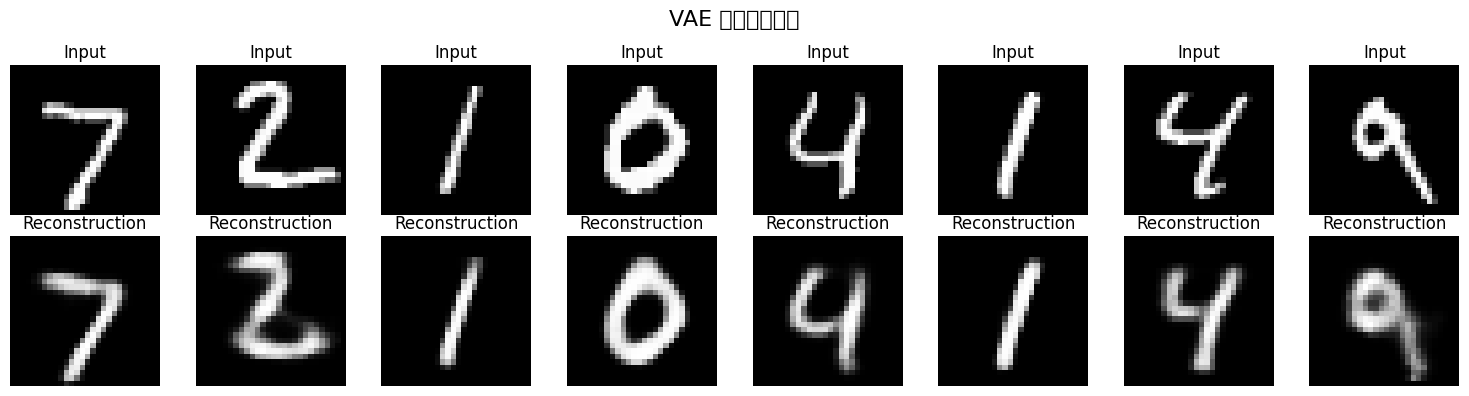

In [ ]:
# 生成重建結果視覺化
print("\n生成重建結果...")
visualize_reconstruction(model, test_loader, device)

In [ ]:
# 6. 生成新樣本
def generate_samples(model, device, num_samples=8):
    """從潛在空間生成新樣本"""
    model.eval()

    with torch.no_grad():
        # 從標準正態分佈採樣
        z = torch.randn(num_samples, LATENT_DIM).to(device)
        generated = model.decode(z).cpu().view(-1, 1, 28, 28)

    # 繪圖
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))

    for i in range(num_samples):
        axes[i].imshow(generated[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Generated {i+1}')
        axes[i].axis('off')

    plt.suptitle('VAE 生成的新樣本', fontsize=16)
    plt.tight_layout()
    plt.savefig('generated_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

生成新樣本...


/tmp/ipython-input-3162981832.py:20: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3162981832.py:20: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3162981832.py:20: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3162981832.py:20: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3162981832.py:20: UserWarning: Glyph 27171 (\N{CJK UNIFIED IDEOGRAPH-6A23}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3162981832.py:20: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3162981832.py:21: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missi

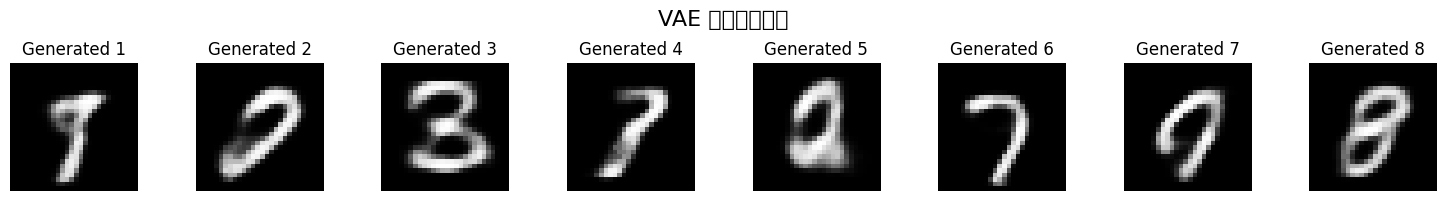

In [ ]:
print("生成新樣本...")
generate_samples(model, device)

/tmp/ipython-input-3301458024.py:9: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-3301458024.py:9: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-3301458024.py:9: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-3301458024.py:9: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-3301458024.py:9: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-3301458024.py:9:

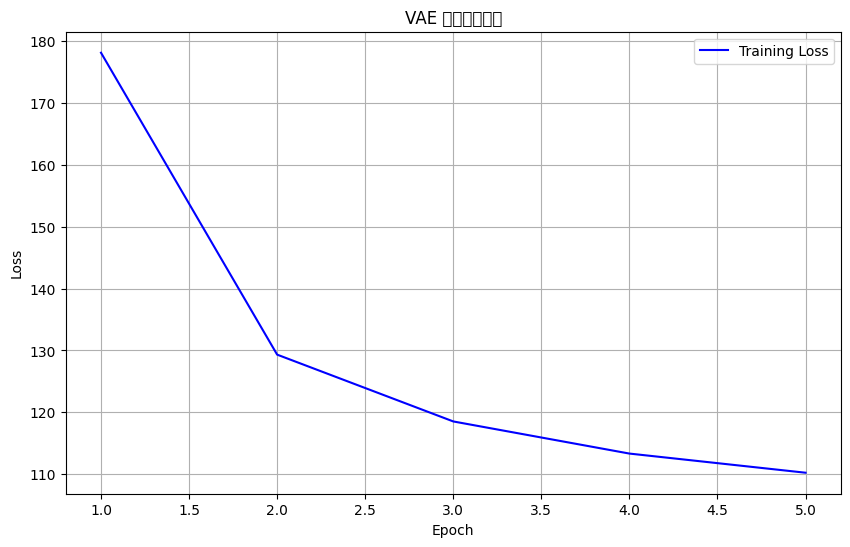

In [ ]:
# 7. 損失曲線
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE 訓練損失曲線')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# 8. 潛在空間視覺化 (2D)
def visualize_latent_space(model, test_loader, device):
    """視覺化潛在空間 (僅適用於 2D 潛在空間)"""
    if LATENT_DIM != 2:
        print("潛在空間視覺化僅適用於 2D 潛在空間")
        return

    model.eval()
    z_points = []
    labels = []

    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, INPUT_DIM))
            z_points.extend(mu.cpu().numpy())
            labels.extend(label.numpy())

    z_points = np.array(z_points)
    labels = np.array(labels)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_points[:, 0], z_points[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('潛在空間視覺化')
    plt.savefig('latent_space.png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
# 如果使用 2D 潛在空間，可以視覺化
if LATENT_DIM == 2:
    print("視覺化潛在空間...")
    visualize_latent_space(model, test_loader, device)

print("\n所有結果已生成完成！")
print("生成的圖片檔案：")
print("- reconstruction.png: 重建結果比較")
print("- generated_samples.png: 生成的新樣本")
print("- training_loss.png: 訓練損失曲線")
if LATENT_DIM == 2:
    print("- latent_space.png: 潛在空間視覺化")


所有結果已生成完成！
生成的圖片檔案：
- reconstruction.png: 重建結果比較
- generated_samples.png: 生成的新樣本
- training_loss.png: 訓練損失曲線


In [ ]:
# 儲存模型
torch.save(model.state_dict(), 'vae_mnist_model.pth')
print("模型已儲存為 vae_mnist_model.pth")

模型已儲存為 vae_mnist_model.pth
